In [1]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from katrain.core.base_katrain import KaTrainBase
from katrain.core.game import Game, KaTrainSGF
from katrain.core.engine import KataGoEngine

[INFO   ] [Logger      ] Record log in /home/sander/.kivy/logs/kivy_20-06-12_26.txt
[INFO   ] [Kivy        ] v2.0.0rc2, git-Unknown, 20200603
[INFO   ] [Kivy        ] Installed at "/home/sander/anaconda3/lib/python3.7/site-packages/kivy/__init__.py"
[INFO   ] [Python      ] v3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
[INFO   ] [Python      ] Interpreter at "/home/sander/anaconda3/bin/python"
 /home/sander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
 A value is trying to be set on a copy of a slice from a DataFrame.
 Try using .loc[row_indexer,col_indexer] = value instead
 
 See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
   
 /home/sander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
 A value is trying to be set on a copy of a slice from a DataFrame.
 Try using .loc[row_indexer,col_indexer] = value instead
 


In [2]:
kt = KaTrainBase(force_package_config=True)

In [3]:
e_config = kt.config("engine")
e_config["max_visits"] = e_config["fast_visits"] = 1  # since it's just policy anyway
e_config["threads"] = 72
e_config

{'katago': '',
 'model': 'katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz',
 'config': 'katrain/KataGo/analysis_config.cfg',
 'threads': 72,
 'max_visits': 1,
 'fast_visits': 1,
 'max_time': 3.0,
 'wide_root_noise': 0.0,
 '_enable_ownership': True}

In [4]:
engine = KataGoEngine(kt, e_config)

2020-06-12 10:23:54+0200: Analysis Engine starting...
2020-06-12 10:23:54+0200: KataGo v1.4.2+kt1.1 (minified)
2020-06-12 10:23:54+0200: nnRandSeed0 = 10658678194122093914
2020-06-12 10:23:54+0200: After dedups: nnModelFile0 = /home/sander/anaconda3/lib/python3.7/site-packages/katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz useFP16 auto useNHWC auto
2020-06-12 10:23:55+0200: Found OpenCL Platform 0: NVIDIA CUDA (NVIDIA Corporation) (OpenCL 1.2 CUDA 10.2.131)
2020-06-12 10:23:55+0200: Found 1 device(s) on platform 0 with type CPU or GPU or Accelerator
2020-06-12 10:23:55+0200: Found OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) (score 11000102)
2020-06-12 10:23:55+0200: Using OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) OpenCL 1.2 CUDA
2020-06-12 10:23:55+0200: Loaded tuning parameters from: /home/sander/.katrain/opencltuning/tune6_gpuGeForceGTX1050TiwithMaxQDesign_x19_y19_c192_mv8.txt
2020-06-12 10:23:55+0200: Note

In [13]:
PLAYERS={'W':'white','B':'black'}

def get_policy_stats(game):
    game.redo(999)
    moves = game.current_node.nodes_from_root[1:]  # without root
    while not all(m.analysis_ready for m in moves):
        time.sleep(0.01)

    parent_policy_per_move = [move.parent.policy_ranking for move in moves]
    num_legal_moves = [sum(pv >= 0 for pv,_ in policy_ranking) for policy_ranking in parent_policy_per_move]
    policy_stats = [
        [(move_num, num_mv, rank, value, policy_ranking[0][0], PLAYERS[mv.player]) 
        for rank, (value, mv) in enumerate(policy_ranking) if mv == move.move][0]
        for move_num,(move, policy_ranking, num_mv) in enumerate(zip(moves, parent_policy_per_move, num_legal_moves))
    ]
    return policy_stats


def rank_to_kyu(r):
    return 30-r

def outlier_free_stats(data):
    sorteddata = sorted(data)
    lendata = len(data)
    selected = sorteddata[int(lendata*.2):int(lendata*.8)+1]
    return np.mean(selected)

def normalized_histogram(data, **args):
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, **args)

In [14]:
analyze_games = False

In [15]:
if analyze_games:
    games_data = pd.DataFrame(columns=['bot','bot_rank','user','user_rank','user_color','winner','outcome'])
    moves_data = []


    for filename in tqdm(glob.glob("sgf_ogs/*.sgf")[:100]):
        sgf = KaTrainSGF.parse_file(filename)

        gamedata_str = re.search('Gamedata:(.*)SGF with review',sgf.properties['C'][0],re.DOTALL)[1]
        gamedata = json.loads(gamedata_str)
        outcome = gamedata['outcome']
        rank = {p:rank_to_kyu(gamedata['players'][p]['rank']) for p in ['white','black']}
        players = {p:gamedata['players'][p]['username'] for p in ['white','black']}
        ids = {p:gamedata['players'][p]['id'] for p in ['white','black']}
        bot_player = 'black' if 'katrain-' in players['black'] else 'white'
        non_bot_player = 'black' if bot_player=='white' else 'white'
        winner = 'black' if gamedata['winner']==ids['black'] else 'white'
        gameid = gamedata['game_id']

        if outcome == 'Cancellation' or sgf.board_size!=(19,19) or not gamedata['ranked']:
            continue

        try:
            game = Game(kt, engine, move_tree=sgf)
            move_analysis =  [ (gameid,*stats,non_bot_player) for stats in get_policy_stats(game) ] 
        except Exception as e:
            print(f"Error in analyzing {filename}: {e}") # branching etc
            continue

        games_data.loc[gameid] = (players[bot_player],rank[bot_player],
                              players[non_bot_player],rank[non_bot_player],non_bot_player,
                              winner,outcome)
        game = Game(kt, engine, move_tree=sgf)
        moves_data.append(move_analysis)

    moves_data = pd.DataFrame( sum(moves_data,[]),    
        columns=['game_id','move','num_legal','policy_rank','policy_value','top_value','move_color','user_color'])

    games_data.to_csv('games.csv')
    moves_data.to_csv('moves.csv')
else:
    moves_data = pd.read_csv('moves.csv',index_col=0)
    games_data = pd.read_csv('games.csv',index_col=0)

In [16]:
plt.rcParams.update({'font.size': 22})

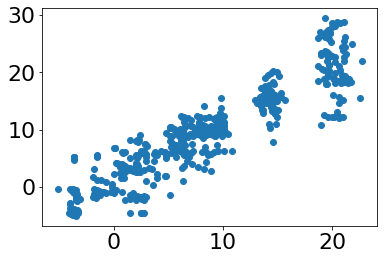

In [17]:
plt.scatter(games_data.bot_rank,games_data.user_rank)

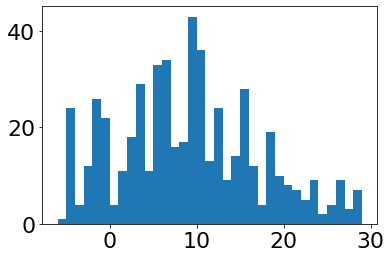

In [18]:
plt.hist(games_data.user_rank,bins=range(-6,30));

In [19]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color]
user_moves['rank'] = games_data.loc[user_moves.game_id].user_rank.values

bot_moves = moves_data[moves_data.move_color!=moves_data.user_color]
bot_moves['rank'] = games_data.loc[bot_moves.game_id].bot_rank.values
labels = ['users','bots']

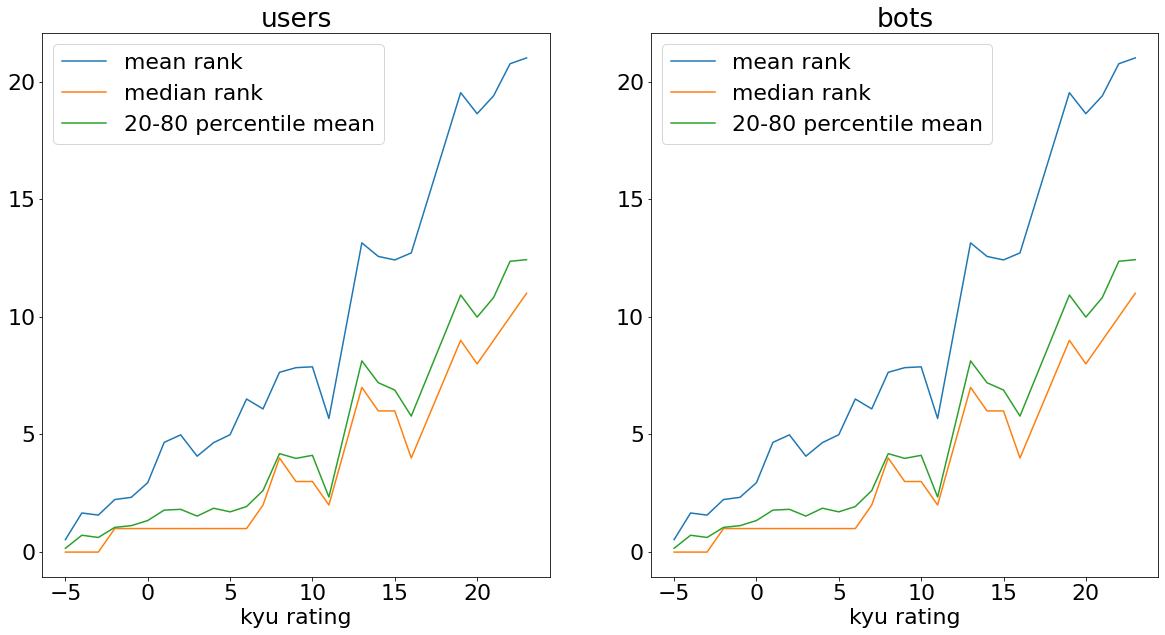

In [20]:
plt.figure(figsize=(20,10))
for i,stats in enumerate([user_moves,bot_moves]):
    stats = [(r,df.policy_rank.mean(),df.policy_rank.median(),outlier_free_stats(df.policy_rank.values),df.shape[0]) 
              for r,df in bot_moves.groupby(bot_moves['rank'].round())]    
    rank, mean, median, outlier_free_mean, sample_size = zip(*stats)
    plt.subplot(1,2,i+1)
    plt.plot(rank,mean,rank,median,rank,outlier_free_mean)
    plt.xlabel('kyu rating')
    plt.legend(['mean rank','median rank','20-80 percentile mean'])
    plt.title(labels[i])

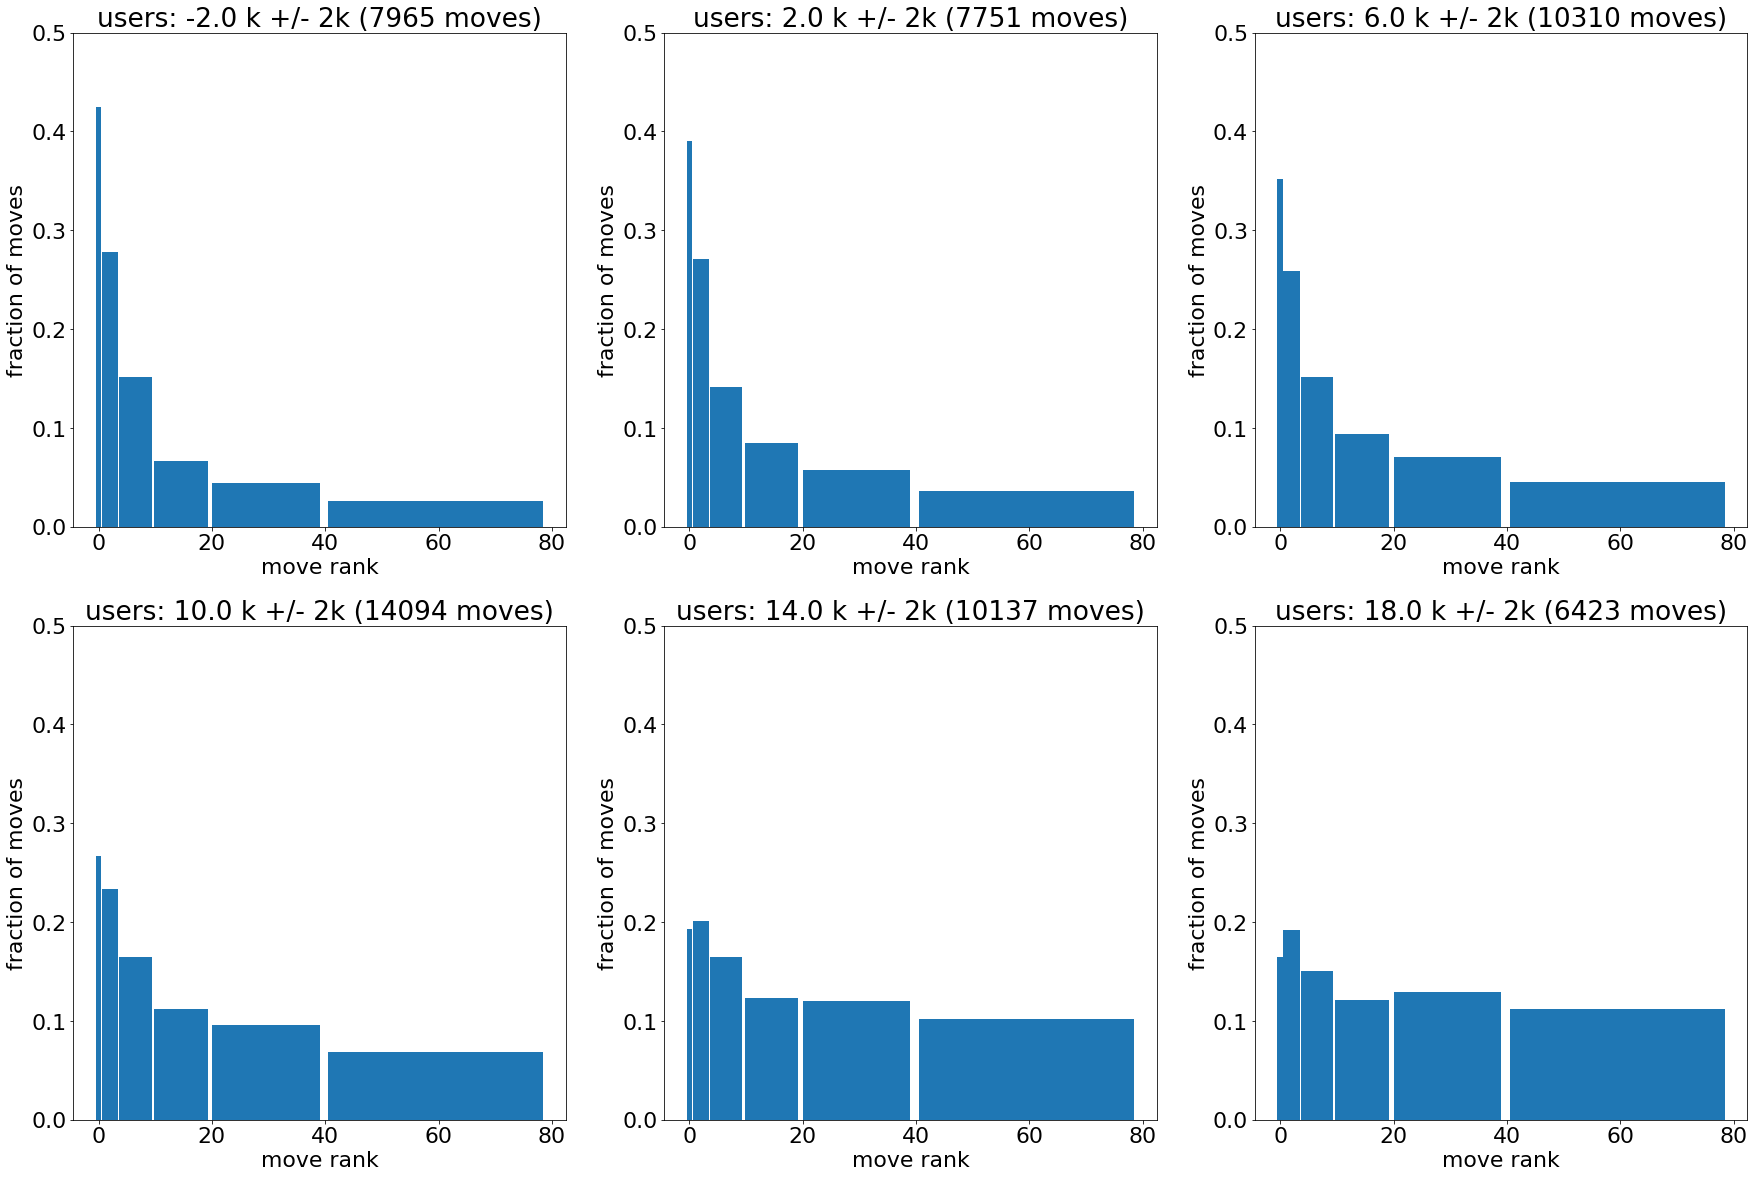

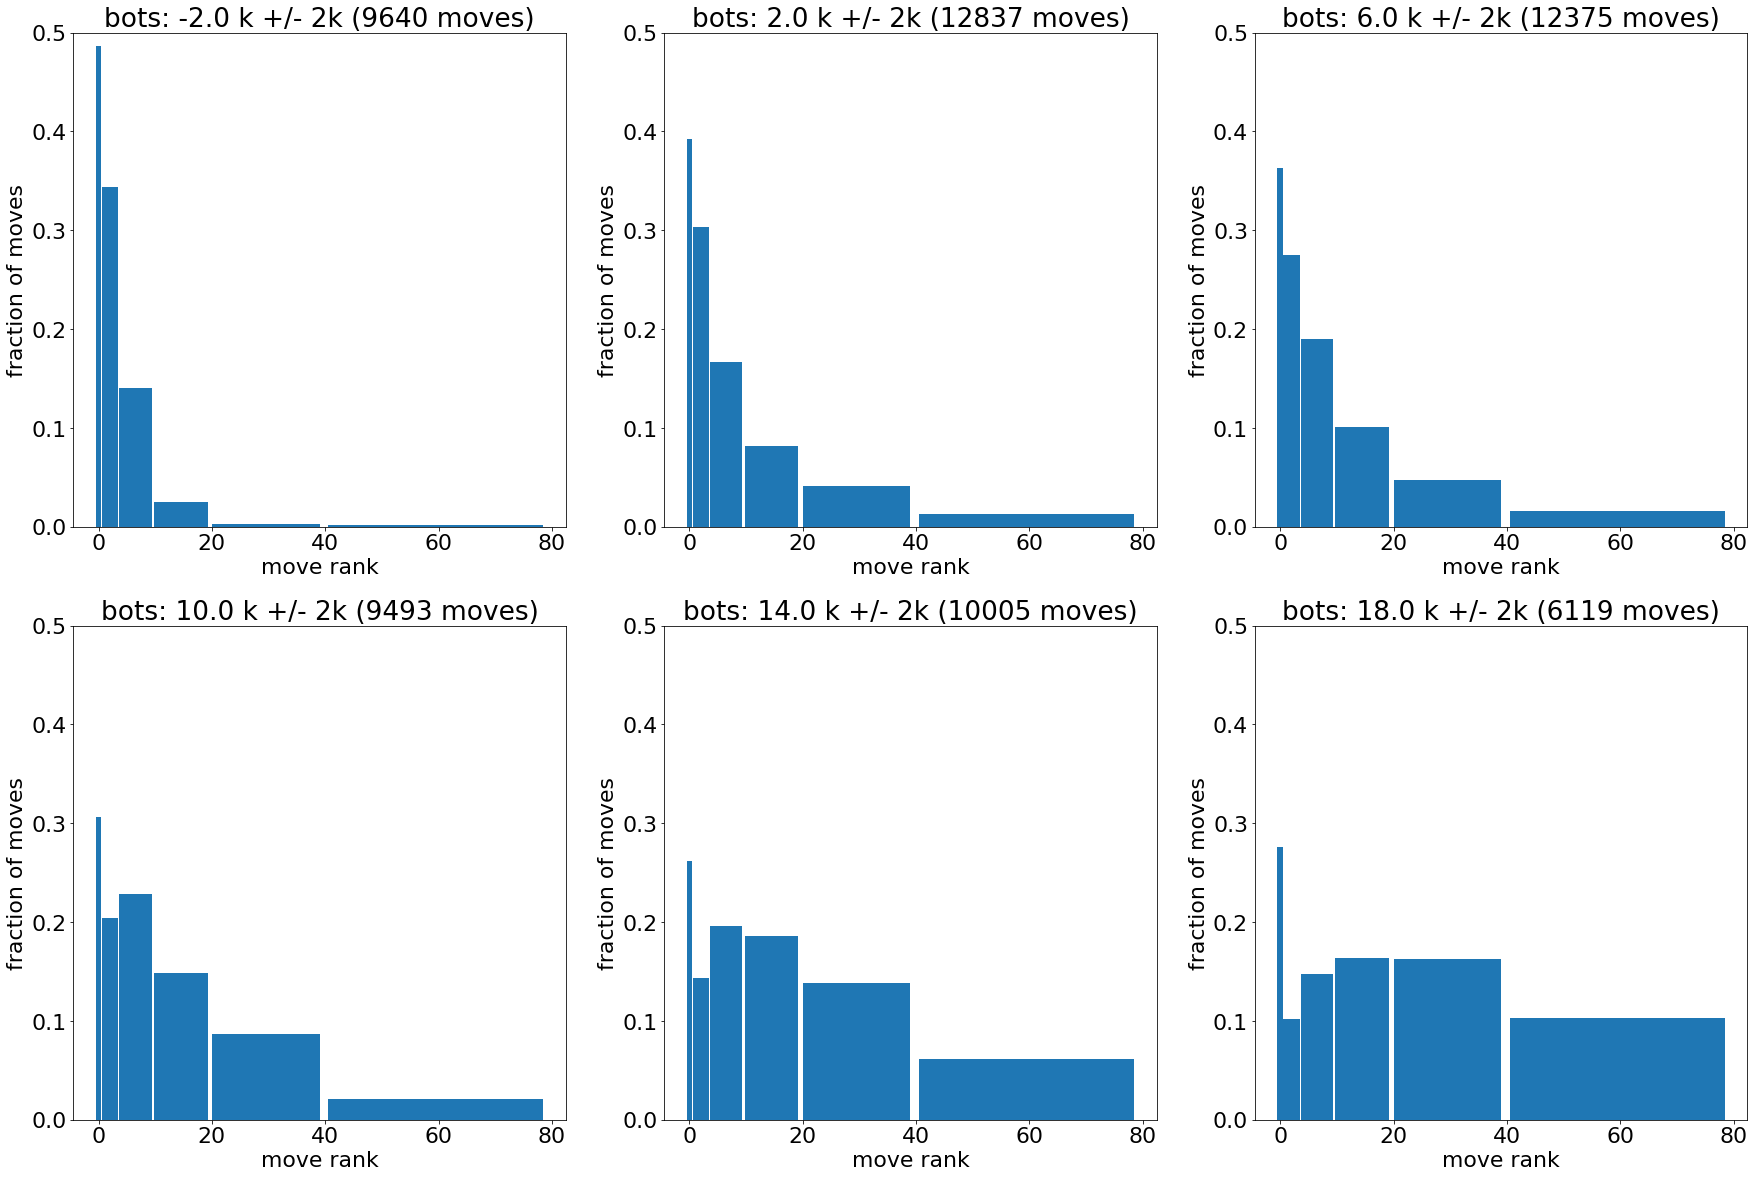

In [24]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.policy_rank.values,bins=[-0.5,0.5,3.5,9.5,19.5,39.5,79.5],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('move rank')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

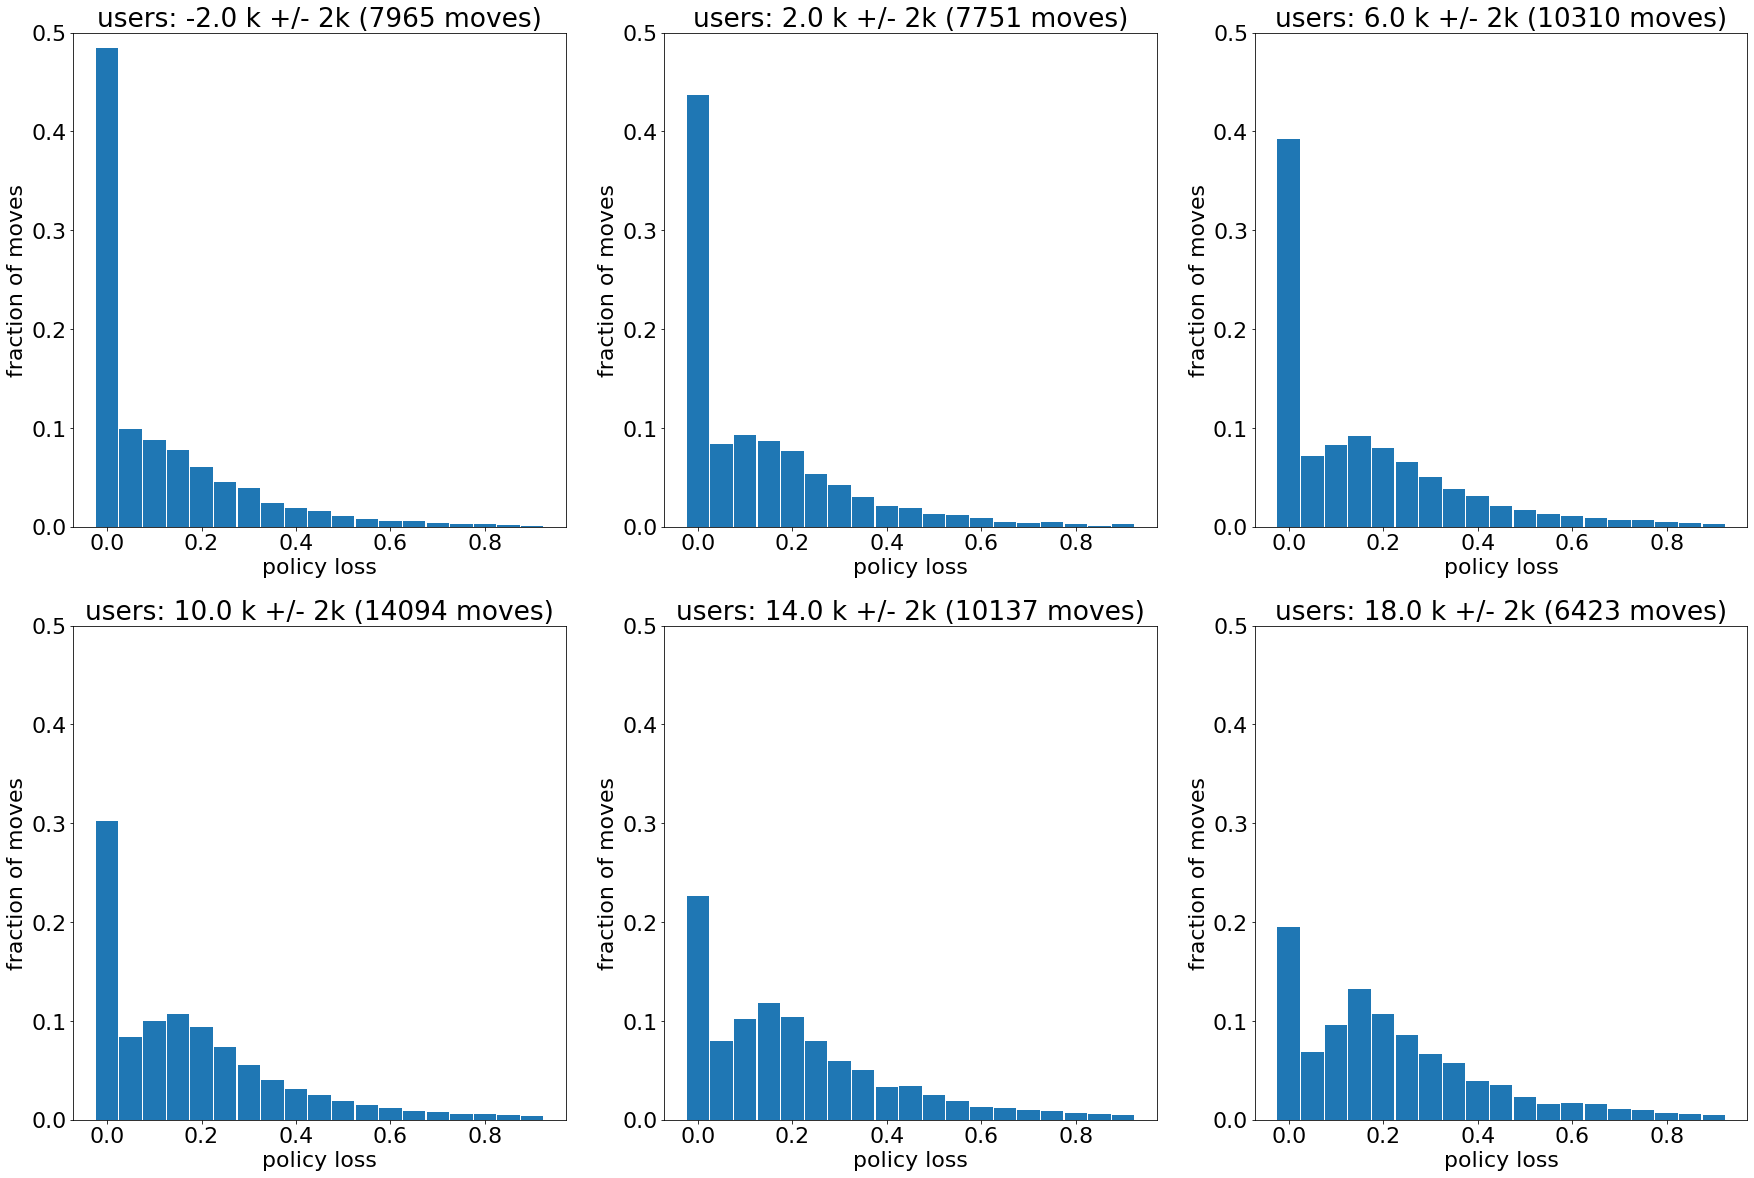

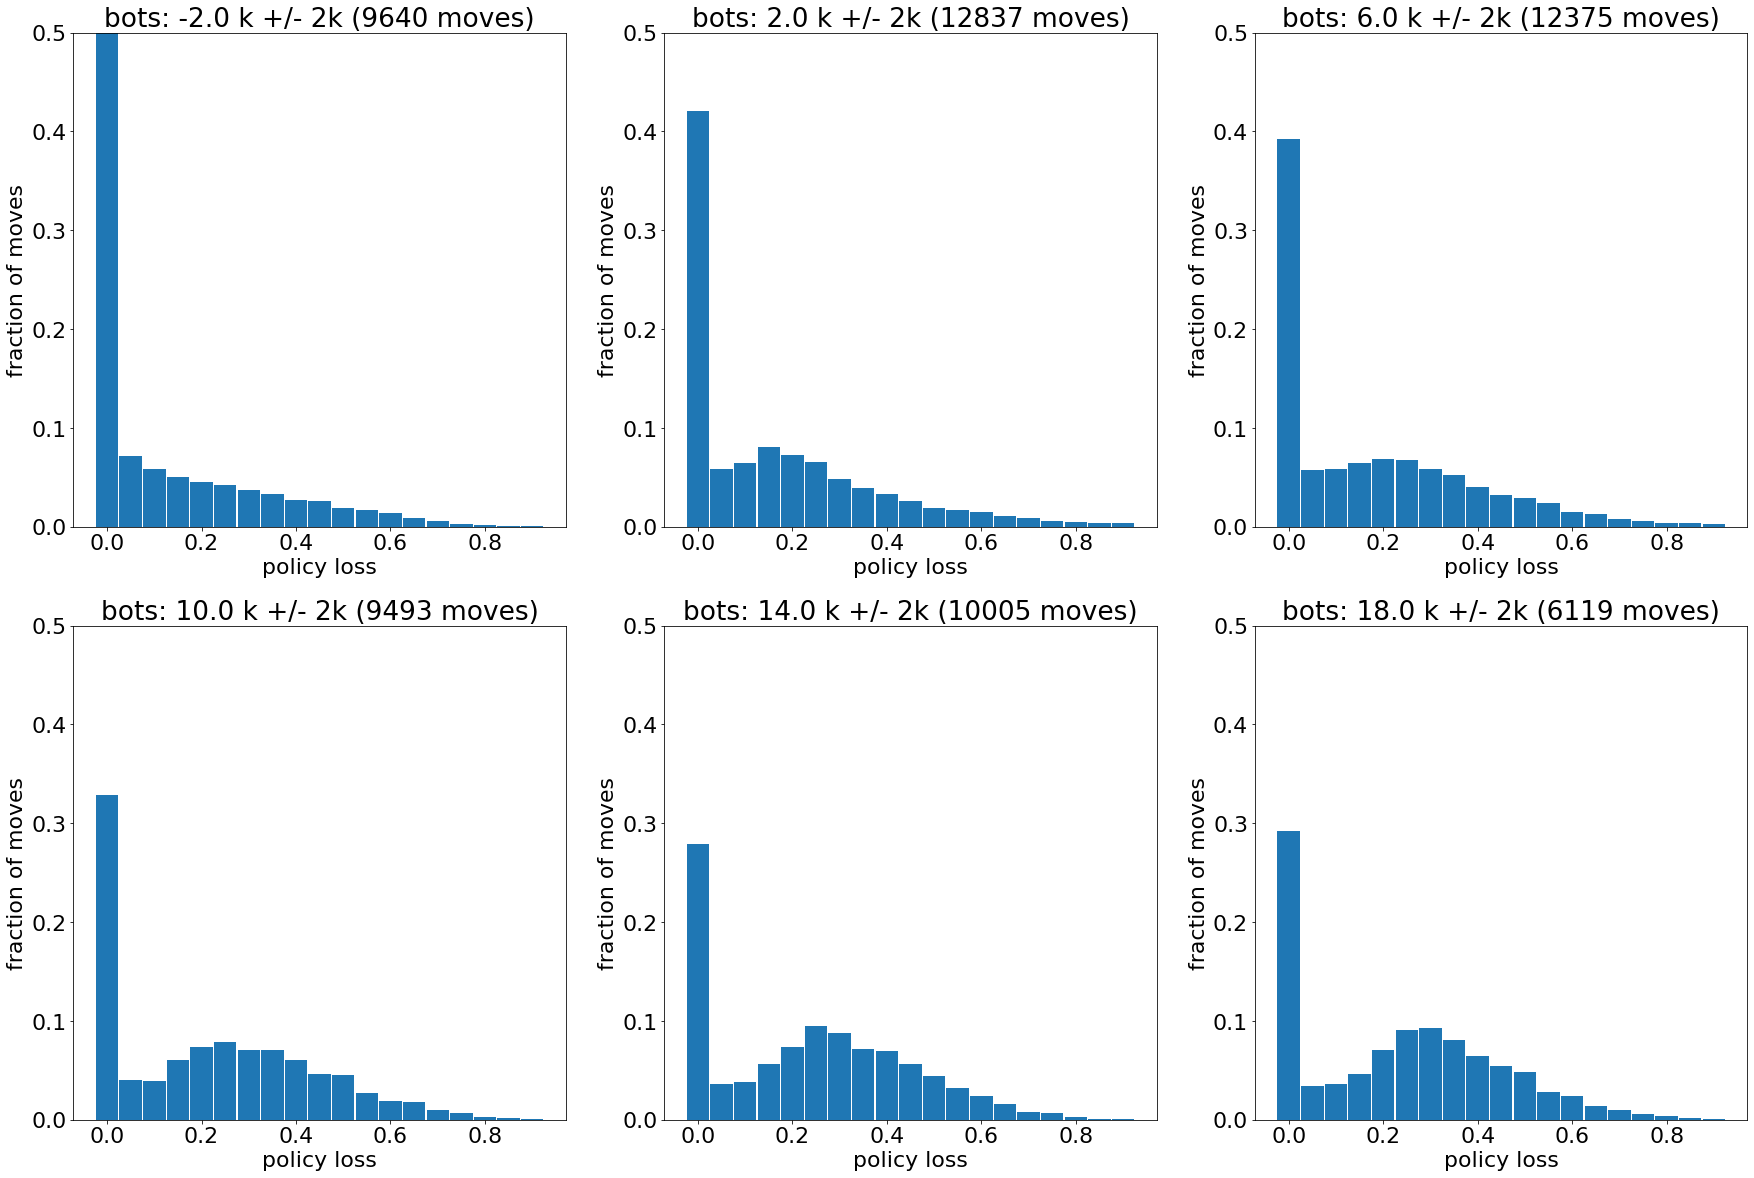

In [31]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.top_value - df.policy_value,bins=np.arange(-0.025,0.975,0.05),rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('policy loss')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

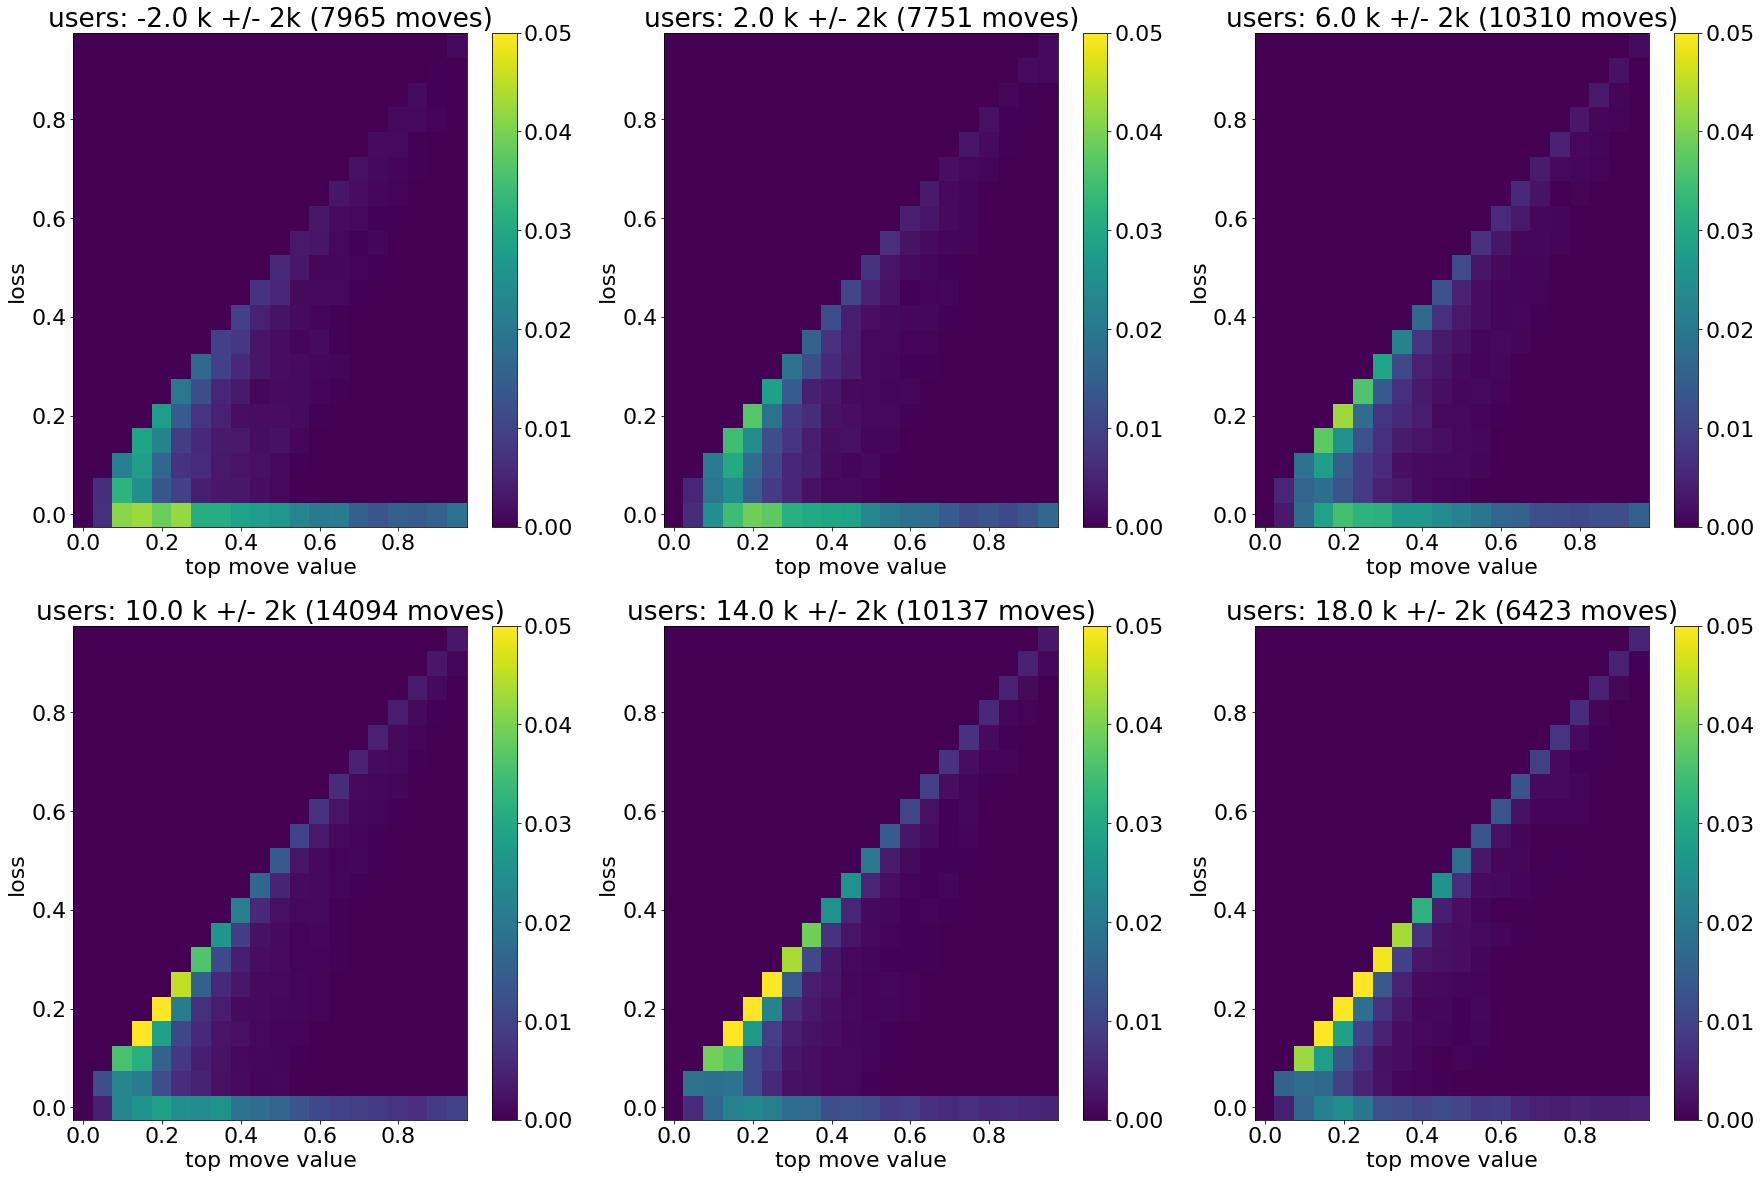

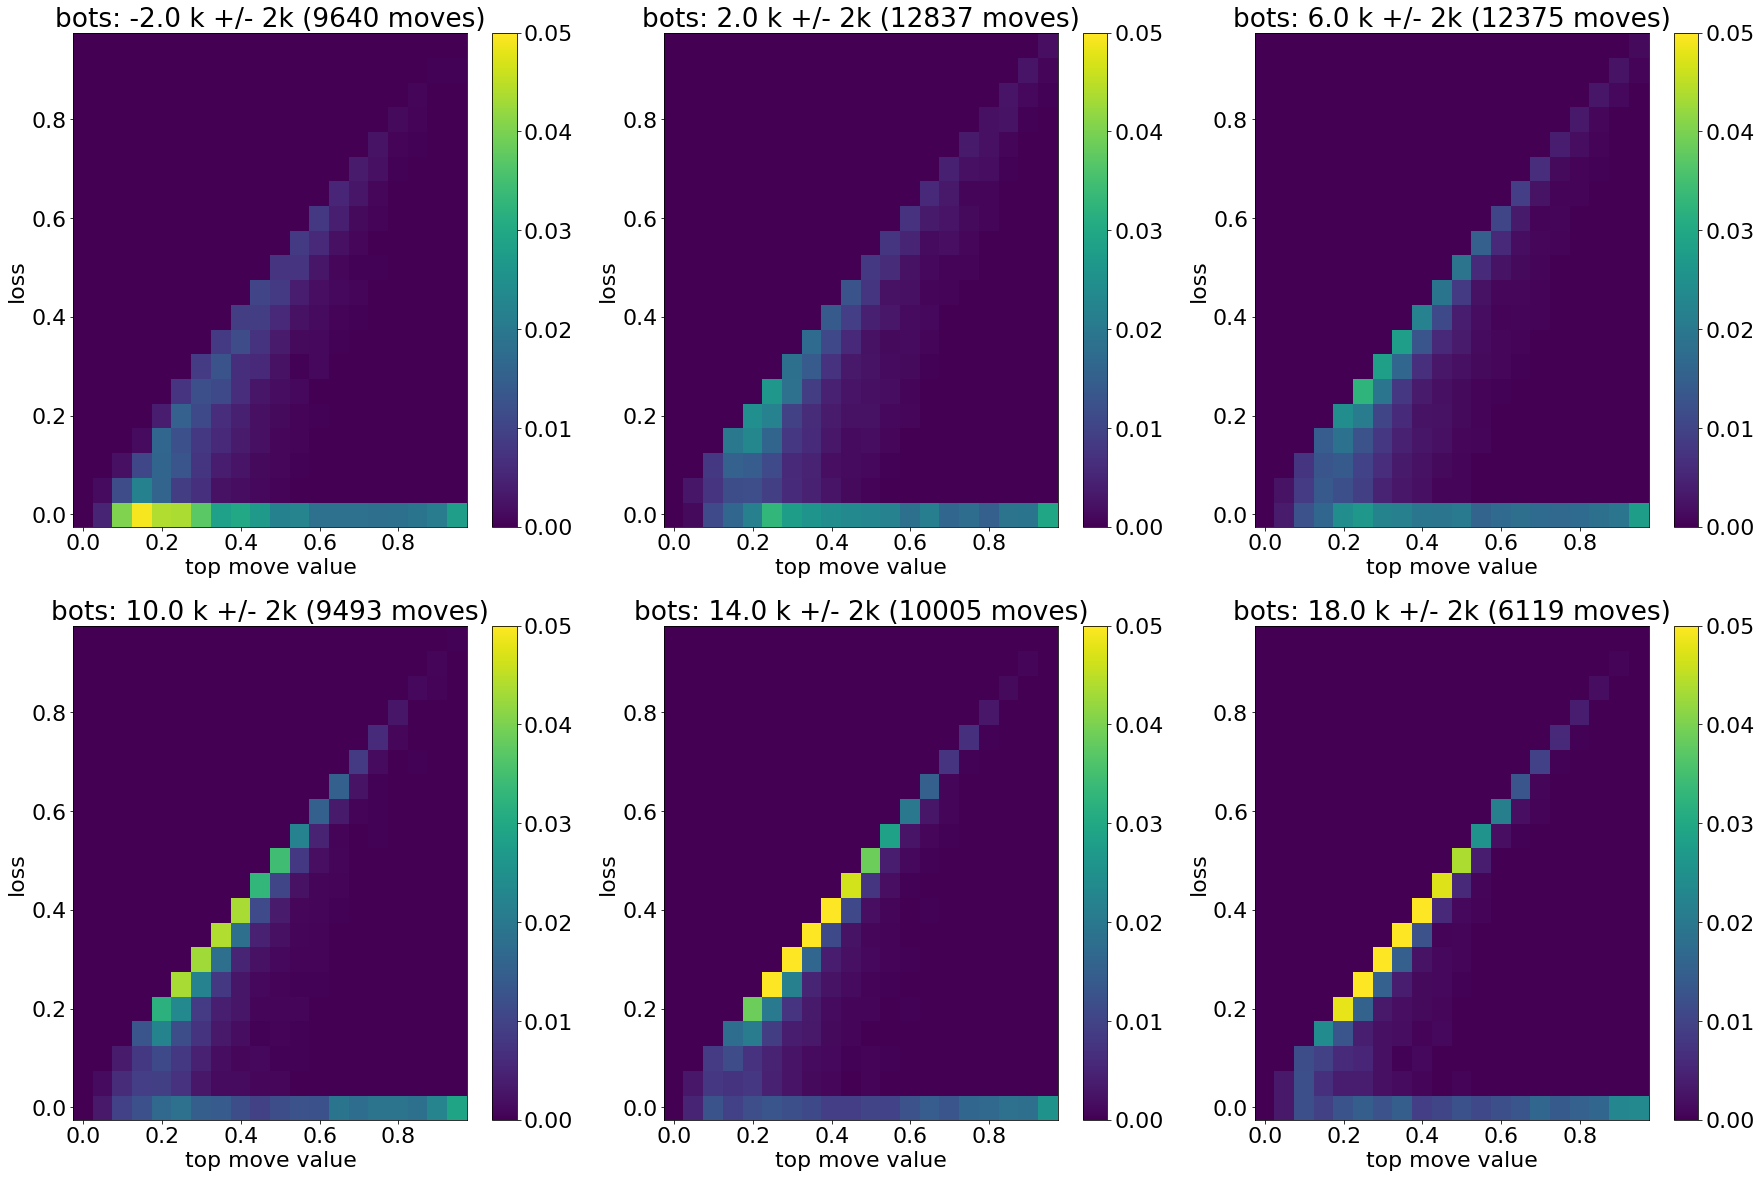

In [44]:
bins = np.arange(-0.025,1.025,0.05)
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        weights = np.ones_like(df.top_value) / len(df.top_value)
        plt.hist2d(df.top_value, df.top_value - df.policy_value,
                            bins=[bins,bins],weights=weights,vmin=0, vmax=0.05)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('top move value')
        plt.ylabel('loss')
        plt.colorbar()

Text(0.5, 1.0, 'bot moves top policy value')

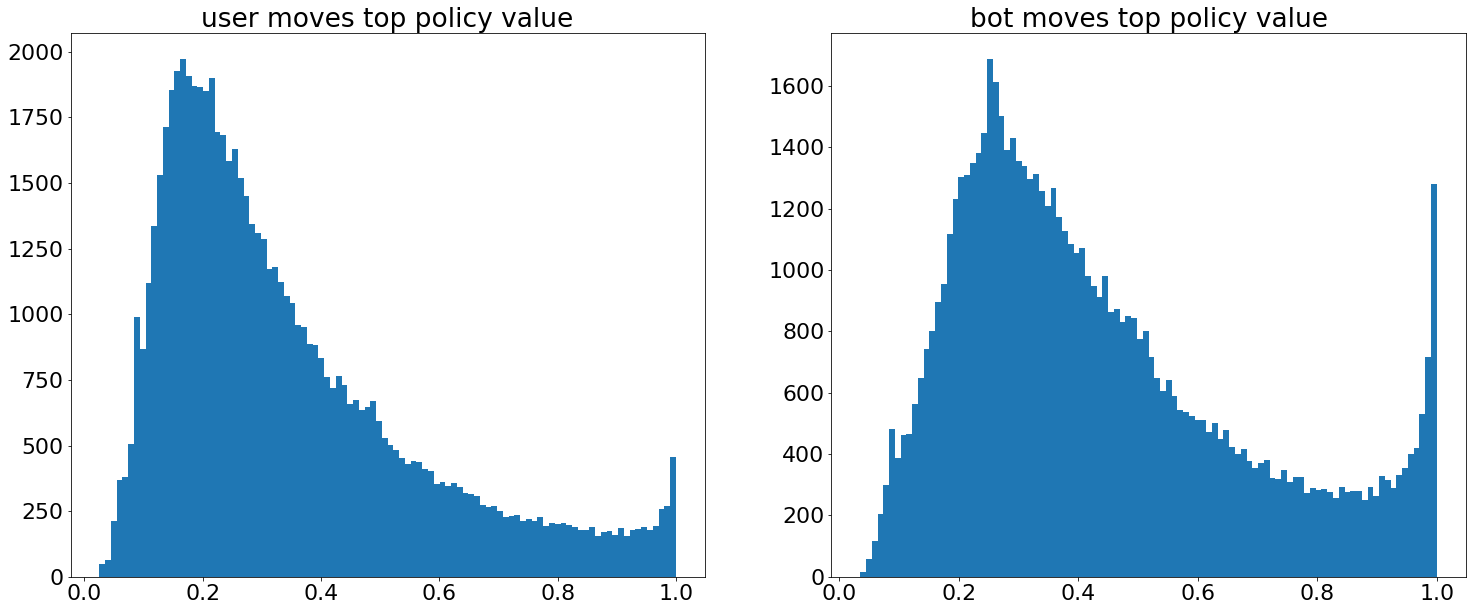

In [56]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1); plt.hist(user_moves.top_value,bins=100); plt.title('user moves top policy value')
plt.subplot(1,2,2); plt.hist(bot_moves.top_value,bins=100); plt.title('bot moves top policy value')